In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

dagnelies_deepfake_faces_path = kagglehub.dataset_download('dagnelies/deepfake-faces')
xhlulu_140k_real_and_fake_faces_path = kagglehub.dataset_download('xhlulu/140k-real-and-fake-faces')
sokhnaballytour_test_progan_path = kagglehub.dataset_download('sokhnaballytour/test-progan')
sokhnaballytour_val_dataset_path = kagglehub.dataset_download('sokhnaballytour/val-dataset')
sokhnaballytour_train_dataset_path = kagglehub.dataset_download('sokhnaballytour/train-dataset')

print('Data source import complete.')


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

# Paramètres
batch_size = 32
img_height = 128
img_width = 128
target_size = (img_height,img_width)

train_dir = '/kaggle/input/train-dataset/train_dataset'
val_dir = '/kaggle/input/val-dataset/val_dataset'
test_dir = '/kaggle/input/test-progan/progan/person'

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)


# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)


test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure test data is not shuffled
)


Found 180030 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
import os
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

def get_data():
    return pd.read_csv('/kaggle/input/deepfake-faces/metadata.csv')

meta=get_data()

real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 16293

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])

def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        # Construct the image path using os.path.join
        image_path = os.path.join('/kaggle/input/deepfake-faces/faces_224', img[:-4] + '.jpg')

        # Check if the image file exists before attempting to load it
        if os.path.exists(image_path):
            image = cv2.imread(image_path)

            # Check if the image was loaded successfully
            if image is not None:
                images.append(image)
                if(imclass=='FAKE'):
                    labels.append(1)
                else:
                    labels.append(0)
            else:
                print(f"Warning: Could not load image at path: {image_path}")
        else:
            print(f"Warning: Image file does not exist at path: {image_path}")

    return np.array(images),np.array(labels)

X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

batch_size = 16

x_train_resized = tf.image.resize(X_train, [128, 128])
x_val_resized = tf.image.resize(X_val, [128, 128])
x_test_resized = tf.image.resize(X_test, [128, 128])

# Normalisation des données (si ce n'est pas déjà fait)
x_train = x_train_resized / 255.0
x_val = x_val_resized / 255.0
x_test = x_test_resized / 255.0


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


def create_deepfake_detection_model(input_shape=(128, 128, 3)):
    with tf.device('/GPU:0'):
        model = models.Sequential()

        # Block 1
        model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
        model.add(layers.BatchNormalization())  # Ajout de BatchNormalization
        model.add(layers.Activation('relu'))
        model.add(layers.Conv2D(64, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.25))

        # Block 2
        model.add(layers.Conv2D(128, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Conv2D(128, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.25))

        # Block 3
        model.add(layers.Conv2D(256, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Conv2D(256, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Conv2D(256, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.25))

        # Block 4
        model.add(layers.Conv2D(512, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Conv2D(512, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Conv2D(512, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.25))

        # Block 5
        model.add(layers.Conv2D(512, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Conv2D(512, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Conv2D(512, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.25))

        # Classification Block
        model.add(layers.Flatten())
        model.add(layers.Dense(4096))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(4096))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(1))
        model.add(layers.Activation('sigmoid'))

        return model

model = create_deepfake_detection_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 32, 32, 256)         │              

 Total params: 65,108,289 (248.37 MB)

 Trainable params: 65,083,457 (248.27 MB)

 Non-trainable params: 24,832 (97.00 KB)

In [ ]:
import time
from tensorflow.keras.callbacks import Callback, EarlyStopping


class TimingCallback(Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()

    def on_train_end(self, logs=None):
        self.train_end_time = time.time()
        training_time = self.train_end_time - self.train_start_time
        print(f"Training completed in {training_time:.2f} seconds.")

# Créer une instance de votre callback personnalisé
timing_callback = TimingCallback()

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model using data augmentation
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator,
                    callbacks=[timing_callback,early_stopping])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5626/5626 ━━━━━━━━━━━━━━━━━━━━ 1315s 226ms/step - accuracy: 0.4996 - loss: 0.9460 - val_accuracy: 0.4975 - val_loss: 0.7092
Epoch 2/10
5626/5626 ━━━━━━━━━━━━━━━━━━━━ 768s 136ms/step - accuracy: 0.5016 - loss: 0.8745 - val_accuracy: 0.4955 - val_loss: 0.8179
Epoch 3/10
5626/5626 ━━━━━━━━━━━━━━━━━━━━ 764s 136ms/step - accuracy: 0.5041 - loss: 0.9515 - val_accuracy: 0.5210 - val_loss: 0.6912
Epoch 4/10
5626/5626 ━━━━━━━━━━━━━━━━━━━━ 789s 140ms/step - accuracy: 0.5052 - loss: 0.9487 - val_accuracy: 0.4960 - val_loss: 0.8712
Epoch 5/10
5626/5626 ━━━━━━━━━━━━━━━━━━━━ 814s 144ms/step - accuracy: 0.5017 - loss: 0.7845 - val_accuracy: 0.4790 - val_loss: 0.6947
Epoch 6/10
5626/5626 ━━━━━━━━━━━━━━━━━━━━ 836s 148ms/step - accuracy: 0.4974 - loss: 0.7007 - val_accuracy: 0.4950 - val_loss: 0.7036
Epoch 7/10
5626/5626 ━━━━━━━━━━━━━━━━━━━━ 798s 142ms/step - accuracy: 0.5008 - loss: 0.6959 - val_accuracy: 0.5250 - val_loss: 0.7490
Epoch 8/10
  90/5626 ━━━━━━━━━━━━━━━━━━━━ 11:28 124ms/step - accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 90s 143ms/step


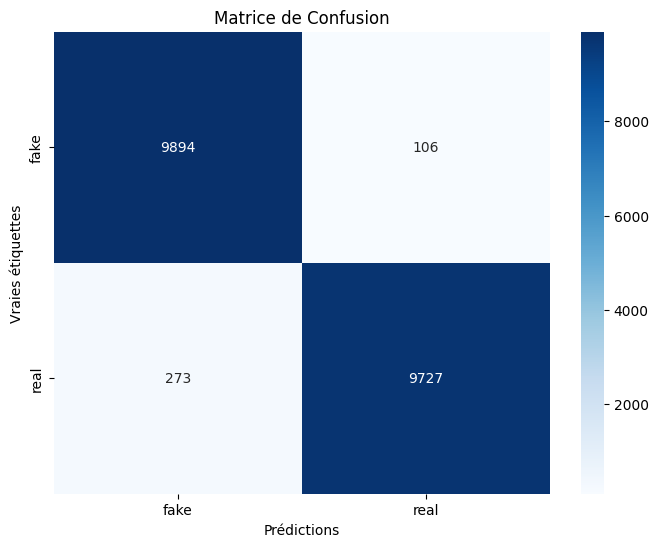

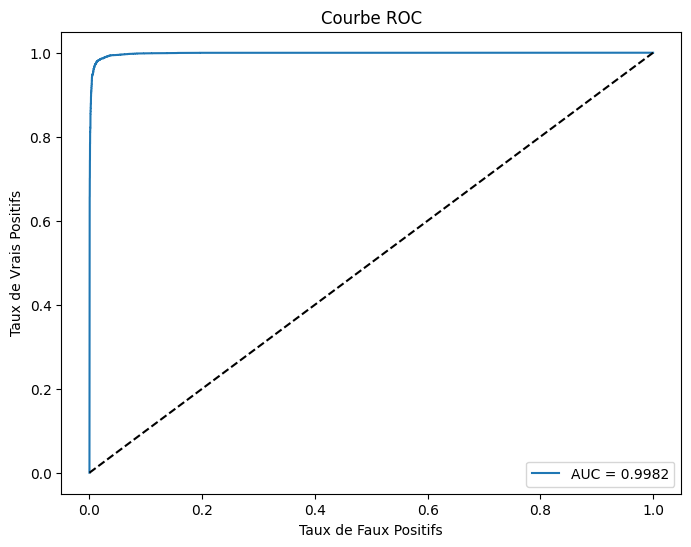

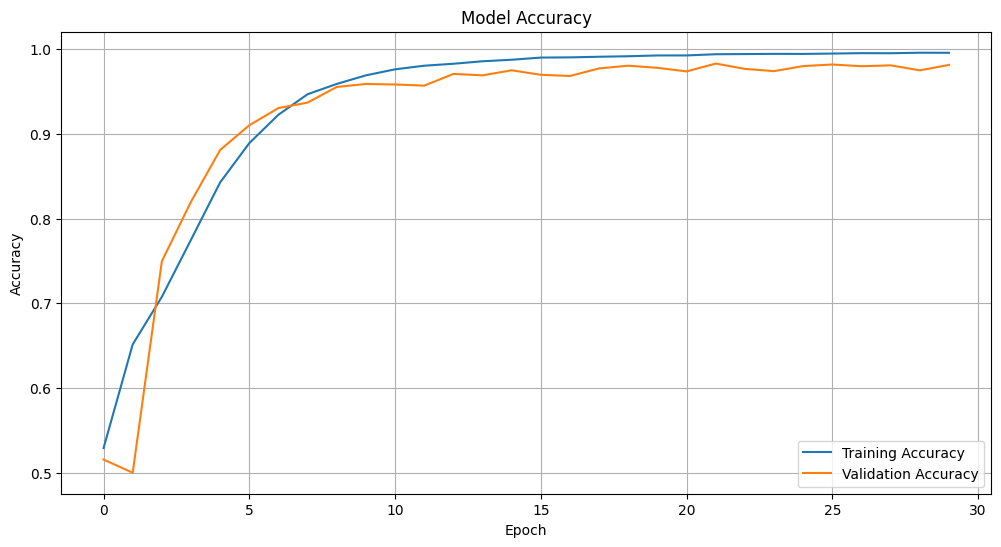

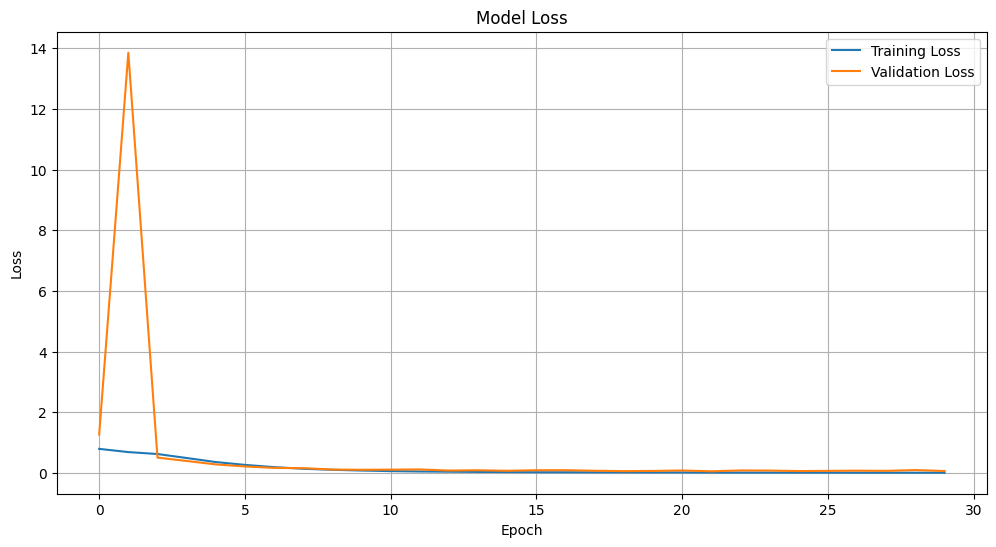

In [ ]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, matthews_corrcoef, cohen_kappa_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns


# Prédictions sur les données de test
test_generator.reset()  # Réinitialiser le générateur de test
predictions = model.predict(test_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

# Obtenir les vraies étiquettes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calcul de la matrice de confusion
cm = confusion_matrix(true_classes, predicted_classes)
tn, fp, fn, tp = cm.ravel()

# Calcul des métriques
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
auc = roc_auc_score(true_classes, predictions)
mcc = matthews_corrcoef(true_classes, predicted_classes)
kappa = cohen_kappa_score(true_classes, predicted_classes)
logloss = log_loss(true_classes, predictions)

# Création d'un dataframe pour stocker les métriques
metrics_dict = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Specificity': specificity,
    'AUC-ROC': auc,
    'MCC': mcc,
    'Cohen Kappa': kappa,
    'Log Loss': logloss
}

metrics_df = pd.DataFrame([metrics_dict])

# Enregistrement des métriques dans un fichier CSV
metrics_df.to_csv('model_metrics.csv', index=False)

# Affichage de la matrice de confusion
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Vraies étiquettes')
plt.xlabel('Prédictions')
plt.title('Matrice de Confusion')
plt.savefig('confusion_matrix.png')
plt.show()

# Tracé de la courbe ROC
fpr, tpr, thresholds = roc_curve(true_classes, predictions)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('accuracy.png')
plt.show()


# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('loss.png')
plt.show()